[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/dynamic-breakpoints.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239526-lesson-4-dynamic-breakpoints)

# Dynamic breakpoints 

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

We covered breakpoints as a general way to stop the graph at specific steps, which enables use-cases like `Approval`

We also showed how to edit graph state, and introduce human feedback. 

## Goals

Breakpoints are set by the developer on a specific node during graph compilation. 

But, sometimes it is helpful to **allow the graph to *dynamically interrupt* itself!**

#### This is an internal breakpoint, and [can be achieved using `NodeInterrupt`](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/dynamic_breakpoints/#run-the-graph-with-dynamic-interrupt).

This has a few specific benefits: 

(1) you can do it **conditionally** (from inside a node based on developer-defined logic).

(2) you can **communicate to the user why its interrupted** (by passing whatever you want to the `NodeInterrupt`).

Let's create a graph where a `NodeInterrupt` is thrown based upon length of the input.

### IMPORTANT NOTE!
NodeInterrupt is DEPRECATED in LG v1.0
 
The whole cell has been commented out and the 
current implementation is right below.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

In [3]:
"""
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    input: str

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt if the length of the input is longer than 5 characters
    if len(state['input']) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")
    
    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    print("---Step 3---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))
"""

'\nfrom IPython.display import Image, display\n\nfrom typing_extensions import TypedDict\nfrom langgraph.checkpoint.memory import MemorySaver\nfrom langgraph.errors import NodeInterrupt\nfrom langgraph.graph import START, END, StateGraph\n\nclass State(TypedDict):\n    input: str\n\ndef step_1(state: State) -> State:\n    print("---Step 1---")\n    return state\n\ndef step_2(state: State) -> State:\n    # Let\'s optionally raise a NodeInterrupt if the length of the input is longer than 5 characters\n    if len(state[\'input\']) > 5:\n        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state[\'input\']}")\n\n    print("---Step 2---")\n    return state\n\ndef step_3(state: State) -> State:\n    print("---Step 3---")\n    return state\n\nbuilder = StateGraph(State)\nbuilder.add_node("step_1", step_1)\nbuilder.add_node("step_2", step_2)\nbuilder.add_node("step_3", step_3)\nbuilder.add_edge(START, "step_1")\nbuilder.add_edge("step_1", "step_2")\nbuilder.add_edge(

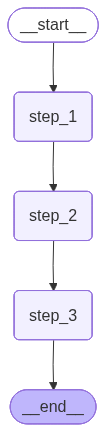

In [4]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph
from langgraph.types import interrupt  # NEW: replace NodeInterrupt

class State(TypedDict):
    input: str

def step_1(state: State):
    print("---Step 1---")
    return state

def step_2(state: State):
    # If input is longer than 5 chars, pause execution here
    if len(state["input"]) > 5:
        # NEW: return an interrupt command (do NOT raise -> deprecated)
        return interrupt(
            f"Received input that is longer than 5 characters: {state['input']}"
        )
    print("---Step 2---")
    return state

def step_3(state: State):
    print("---Step 3---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))


Let's run the graph with an input that's longer than 5 characters. 

In [5]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

# The graph stops on step 2 because of the interruption condition!

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}


If we inspect the graph state at this point, we the node set to execute next (`step_2`).


In [6]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


We can see that the `Interrupt` is logged to state.

In [8]:
print(state.tasks)
# ... interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world'...

(PregelTask(id='3b7c91e8-6831-1569-480e-55049e374e94', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', id='5955af246fd1c67668e6d6f0353ba79a'),), state=None, result=None),)


##### We can try to resume the graph from the breakpoint. 

##### But, this just re-runs the same node! 

#### Unless state is changed **we will be stuck here.**

In [9]:
# Passing None as input to resume wont work here - we're stuck with the same message!
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}


In [10]:
# next is step_2 
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


#### we can update state.

In [11]:
# update state
graph.update_state(
    thread_config, # same thread!
    {"input": "hi"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09ae2e-97ac-6a00-8002-10fcd41cb21b'}}

In [ ]:
# After updating, we can resume by passing None!
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hi'}
---Step 2---
{'input': 'hi'}
---Step 3---
{'input': 'hi'}


### Usage with LangGraph API

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

In [12]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

We connect to it via the SDK.

In [21]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [22]:
thread = await client.threads.create()
input_dict = {"input": "hello world"}

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints", #agent from dynamic_breakpoints.py
    input=input_dict,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '01998784-f384-742a-a8ce-0f549b0b759d', 'attempt': 1}



Receiving new event of type: values...
{'input': 'hello world'}



Receiving new event of type: values...
{'input': 'hello world'}



Receiving new event of type: values...
{'__interrupt__': [{'value': 'Received input that is longer than 5 characters: hello world', 'id': '089f29accc4990f4d2ee35b9c63437e9'}]}





In [23]:
current_state = await client.threads.get_state(thread['thread_id'])

In [24]:
current_state['next']
# stuck on step 2 due to interrupt condition met!

['step_2']

In [25]:
# Updating input! We should move to the other steps now!
await client.threads.update_state(thread['thread_id'], {"input": "hi!"})

{'checkpoint': {'thread_id': 'f9ad2321-7f38-4fe5-8ba9-a3c743e6184e',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09b0fe-026e-6b18-8002-f1b56e8d9040'},
 'configurable': {'thread_id': 'f9ad2321-7f38-4fe5-8ba9-a3c743e6184e',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09b0fe-026e-6b18-8002-f1b56e8d9040'},
 'checkpoint_id': '1f09b0fe-026e-6b18-8002-f1b56e8d9040'}

In [26]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=None,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '01998785-7dba-71af-937c-4ca77ea1ea22', 'attempt': 1}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}





In [20]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state # shows 'step': 4 , so we made it, we bypassed the interruption !

{'values': {'input': 'hi!'},
 'next': [],
 'tasks': [],
 'metadata': {'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'langgraph_request_id': '5c3cf389-b04d-46a0-83fa-1a232300613f',
  'graph_id': 'dynamic_breakpoints',
  'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'user_id': '',
  'created_by': 'system',
  'run_attempt': 1,
  'langgraph_version': '0.6.7',
  'langgraph_api_version': '0.4.20',
  'langgraph_plan': 'developer',
  'langgraph_host': 'self-hosted',
  'langgraph_api_url': 'http://127.0.0.1:2024',
  'run_id': '01998783-a060-773f-88bf-1b6b3edeb97e',
  'thread_id': '8c307b85-89be-4bb0-a70e-5d21b32158a1',
  'source': 'loop',
  'step': 4,
  'parents': {}},
 'created_at': '2025-09-26T19:32:55.205410+00:00',
 'checkpoint': {'checkpoint_id': '1f09b0f9-9962-65f0-8004-6121e5645ae2',
  'thread_id': '8c307b85-89be-4bb0-a70e-5d21b32158a1',
  'checkpoint_ns': ''},
 'parent_checkpoint': {'checkpoint_id': '1f09b0f9-995a-6053-800

## Note
As for today, the dynamic breakpoints are not working in the studio (buggy with the interruption and state update)